### Setup

In [1]:
# import networkx as nx
import json
import os
import yaml
from textwrap import dedent
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exec(open("/tools/C/nayiri/power/scripts/variables.py").read())
exec(open(f"{scripts_dir}/util.py").read())

In [3]:
exec(open(f"{scripts_dir}/util.py").read())

my_rtl = 'GemminiRocketConfigWS'
my_module = 'Gemmini'
power_level = 'rtl'
num_toggles = N_CYCLES
# my_workloads = ['matmul_os-baremetal', 'matmul_ws-baremetal']
# my_workloads = ['tiled_matmul_ws_perf-baremetal']
my_workloads = gemmini_tiled_matmul
w_data_dict = {w: {'profile_report_name': get_run_name(w,my_rtl,module=my_module,num_toggles=num_toggles)} for w in my_workloads}
overwrite = False

# opm_signal_configs = add_opms_to_verilog(my_rtl)

In [4]:
exec(open(f"{scripts_dir}/util.py").read())
add_final_cntr_to_verilog(my_rtl)

### Run RTL Sim

#### Commit log

In [5]:
exec(open(f"{scripts_dir}/util.py").read())
print_sim_out_commands(my_workloads,my_rtl,overwrite=overwrite)

#### FSDB Waveform

In [6]:

print_sim_commands(my_workloads,my_rtl,overwrite=overwrite, overwrite_simv=False)

#### Get start times from .out file

In [7]:
exec(open(f"{scripts_dir}/util.py").read())
get_workload_starttimes(my_workloads,my_rtl,module=my_module,d=w_data_dict);

### Parse RTL Sim Waveforms

In [12]:
exec(open(f"{scripts_dir}/util.py").read())
print_fsdb_commands(my_workloads,my_rtl,my_module,w_data_dict=w_data_dict, overwrite=False)


### Run Hammer + Joules
Generate Hammer YAML Config + Commands to create one report per waveform

In [9]:
exec(open(f"{scripts_dir}/util.py").read())
print_joules_commands(my_workloads,rtl=my_rtl,module=my_module,w_data_dict=w_data_dict,overwrite=True)

# report
# print_joules_commands(my_workloads,rtl=my_rtl,w_data_dict=w_data_dict,output_formats=['report'], overwrite=overwrite)


export HAMMER_EXTRA_ARGS="-p /tools/scratch/nayiri/power/chipyard-intech16-sep23/vlsi/nk.yml -p /tools/scratch/nayiri/power/out/yaml_configs/hammer-joules/GemminiRocketConfigWS.yml" && export BINARY=/tools/C/nayiri/power/gemmini-rocc-tests/build/bareMetalC/tmw-0-0-1-0-0-256-16-256-r-r-0-baremetal && export CONFIG=GemminiRocketConfigWS 
bsubq "echo GemminiRocketConfigWS && make redo-power-rtl"


### Get power traces

In [13]:
for w in my_workloads:
    profile_file = get_power_filepath(w,my_rtl,module=my_module)
    # print(profile_file)
    if os.path.exists(profile_file):
        cycles,power = read_profile_file(profile_file=profile_file)
        w_data_dict[w]['jpower'] = power
        w_data_dict[w]['cycles'] = cycles
    else:
        # print(w)
        w_data_dict.pop(w, "")

In [14]:
for w in w_data_dict:
    power = w_data_dict[w]['jpower']
    avgpow = sum(power)/len(power)
    length = w_data_dict[w]['cycles'][-1] - w_data_dict[w]['cycles'][0]
    w_data_dict[w]['avgpow'] = avgpow
    w_data_dict[w]['maxpow'] = max(power)
    w_data_dict[w]['energy'] = avgpow*length*1e-6 # mW*ns -> mW*s = mJ


ValueError: max() arg is an empty sequence

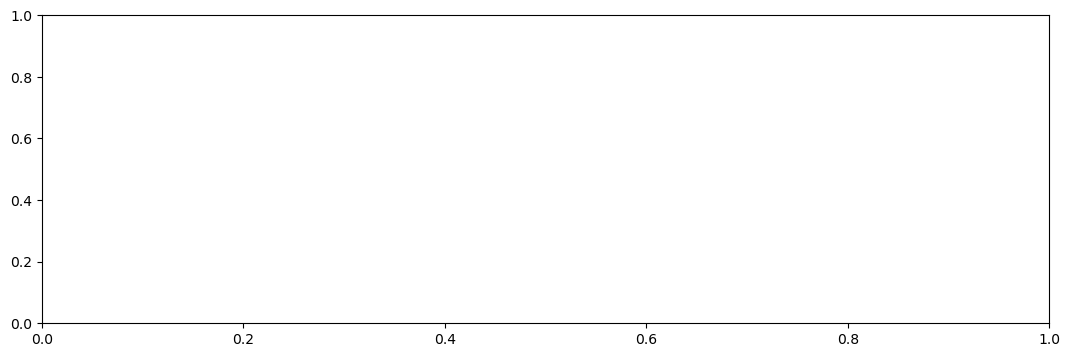

In [15]:
jpower = [p for w in w_data_dict for p in w_data_dict[w]['jpower']]

plot_power(jpower)


In [10]:
exec(open(f"{scripts_dir}/util.py").read())

toggles, jpower, wb = get_workloads_toggles_jpower(my_workloads, my_rtl, module=my_module)
ret_dict = apollo(toggles, toggles, jpower, jpower, verbose=True)


MemoryError: Unable to allocate 1.05 TiB for an array with shape (578507442176,) and data type uint16

In [ ]:
dump_opms_to_yaml(my_rtl)

In [ ]:
exec(open(f"{scripts_dir}/util.py").read())
print_sim_opm_commands(my_workloads,my_rtl,overwrite=overwrite)